In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))

SEED=1234
n_splits=10

In [2]:
train=pd.read_csv('./input/prep_train1030.csv')
test=pd.read_csv('./input/prep_train1030.csv')
y_train = train['賃料']


In [3]:
train.head(1)

,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,バス・トイレ別,専用トイレ,洗面台独立,共同バス,トイレなし,シャワー,バスなし,浴室乾燥機,温水洗浄便座,追焚機能,-,専用バス,脱衣所,共同トイレ,山手線,中央線,大江戸線,丸ノ内線,三田線,新宿線,総武線,東西線,有楽町線,日比谷線,西武池袋線,京王線,西武新宿線,東武東上線,浅草線,京浜東北線,千代田線,本線,南北線,小田急小田原線,田園都市線,京王井の頭線,池上線,東横線,京成本線,大井町線,半蔵門線,常磐線,世田谷線,目黒線,新築,畳,インターネット対応,BSアンテナ,CATV,有線放送,高速インターネット,インターネット使用料無料,CSアンテナ,光ファイバー,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【コインパーキング】_dis,【コインパーキング】_num,【病院】_dis,【病院】_num,【飲食店】_dis,【飲食店】_num,【公園】_dis,【公園】_num,【総合病院】_dis,【総合病院】_num,【クリーニング】_dis,【クリーニング】_num,【大学】_dis,【大学】_num,【学校】_dis,【学校】_num,【コンビニ】_dis,【コンビニ】_num,【月極駐車場】_dis,【月極駐車場】_num,【デパート】_dis,【デパート】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【郵便局】_dis,【郵便局】_num,【銀行】_dis,【銀行】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【スーパー】_dis,【スーパー】_num,【図書館】_dis,【図書館】_num,【小学校】_dis,【小学校】_num,室外洗濯機置場,エアコン付,ロフト付き,室内洗濯機置場,トランクルーム,排水その他,二世帯住宅,水道その他,ウォークインクローゼット,冷房,都市ガス,ルーフバルコニー,地下室,フローリング,ガス暖房,タイル張り,床下収納,二重サッシ,汲み取り,クッションフロア,出窓,エレベーター,ペアガラス,井戸,オール電化,シューズボックス,ガスその他,バルコニー,24時間換気システム,防音室,専用庭,下水,敷地内ごみ置き場,公営水道,床暖房,プロパンガス,バリアフリー,洗濯機置場なし,2面採光,石油暖房,3面採光,浄化槽,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ設置可（コンロ1口）,カウンターキッチン,ガスコンロ,コンロ3口,コンロ設置可（口数不明）,システムキッチン,IHコンロ,給湯,コンロ4口以上,コンロ設置可（コンロ4口以上）,コンロ2口,冷蔵庫あり,L字キッチン,独立キッチン,コンロ設置可（コンロ2口）,電気コンロ,コンロ1口,コンロ設置可（コンロ3口）,駐輪場,バイク置き場,sta_mean,sta_min,sta_max,nearest_sta,second_sta,third_sta,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min
0,1,24,RC（鉄筋コンクリート）,1.0,南東,117,75000.0,1K,20.01,-,1,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,1,1,0,0,0,1,0,35.748456,139.7288,8179.773244,北区,滝野川,0,0,0,0,0,0,378,1,1103,1,0,0,0,0,461,1,0,0,588,1,0,0,0,0,956,1,1246,1,0,0,0,0,0,0,311,2,0,0,495,2,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,12.0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,空有,-,652.916349,573.71655,856.219373,西巣鴨駅,西ケ原四丁目駅,板橋駅,488617.0,591280.0,21.0,488617.0,488617.0,488617.0,591280.0,591280.0,591280.0,21.0,21.0,21.0


In [4]:
drop_col = ['id','賃料']
## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)
features = ['面積','築年数','sta_min','center_dis','loc_lat','loc_lon','総階数','所在階','2017平均単価_mean','山手線','千代田線','日比谷線','丸ノ内線']
X_train = X_train[features]
X_test = X_test[features]

In [5]:
# features = ['面積','築年数','sta_min','center_dis','loc_lat','loc_lon','総階数','畳','所在階','追焚機能','方角','BSアンテナ','L','建物構造','戸建て',
#             '室内洗濯機置場','IHコンロ','駐輪場','駐車場','2017平均単価_mean','LDK','DK','部屋数','ウォークインクローゼット','city','city2']



In [6]:
X_train

,面積,築年数,sta_min,center_dis,loc_lat,loc_lon,総階数,所在階,2017平均単価_mean,山手線,千代田線,日比谷線,丸ノ内線
0,20.01,117,573.716550,8179.773244,35.748456,139.728800,12.0,1.0,591280.0,0,0,0,0
1,16.50,538,505.869208,3368.632618,35.662885,139.778627,10.0,5.0,735032.0,0,0,1,0
2,22.05,102,769.293519,7132.274400,35.675153,139.666255,15.0,12.0,677545.0,0,0,0,0
3,60.48,352,581.765019,9145.291052,35.700170,139.648465,4.0,3.0,618133.0,0,0,0,1
4,39.66,379,382.935960,15279.706024,35.766431,139.872321,2.0,1.0,361454.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31462,37.90,360,673.460922,13286.923816,35.782103,139.677100,3.0,1.0,413310.0,0,0,0,0
31463,12.04,475,600.164528,7609.703745,35.648356,139.668082,4.0,4.0,667807.0,0,0,0,0
31464,60.00,550,1200.649184,7706.037818,35.673436,139.830096,5.0,3.0,485120.0,0,0,0,0
31465,29.59,132,688.889548,7556.174543,35.703700,139.668807,2.0,1.0,688104.0,0,0,0,1


In [7]:
from sklearn.preprocessing import LabelEncoder
category_cols = [ '方角', '建物構造']
X_train[category_cols] = X_train[category_cols].fillna('None').astype('category')

X_test[category_cols] = X_test[category_cols].fillna('None').astype('category')
for col in category_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

KeyError: "None of [Index(['方角', '建物構造'], dtype='object')] are in the [columns]"

In [8]:
params = {
    'num_iterations': 15000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'max_depth': -1,
    'colsample_bytree': 1.0,
    'lambda': 1,
    'eta': 0.1,
    'min_child_weight': 1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

NameError: name 'optuna' is not defined

Training on fold 1
28320 3147
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0512656	valid_1's l1: 0.0677613
[1000]	training's l1: 0.0397316	valid_1's l1: 0.0632544
[1500]	training's l1: 0.0324302	valid_1's l1: 0.0610666
[2000]	training's l1: 0.0271897	valid_1's l1: 0.0597648
[2500]	training's l1: 0.0232124	valid_1's l1: 0.0589653
[3000]	training's l1: 0.0201119	valid_1's l1: 0.0581404
[3500]	training's l1: 0.0175304	valid_1's l1: 0.0575921
[4000]	training's l1: 0.015329	valid_1's l1: 0.0571555
[4500]	training's l1: 0.0137114	valid_1's l1: 0.0567661
[5000]	training's l1: 0.0122487	valid_1's l1: 0.0564653
[5500]	training's l1: 0.0109967	valid_1's l1: 0.0562411
Early stopping, best iteration is:
[5710]	training's l1: 0.0105299	valid_1's l1: 0.0561246
start predict
Fold 1 finished in 0:00:06.801901
Training on fold 2
28320 3147
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0517352	valid_1's l1: 0.0666736
[1000]	t

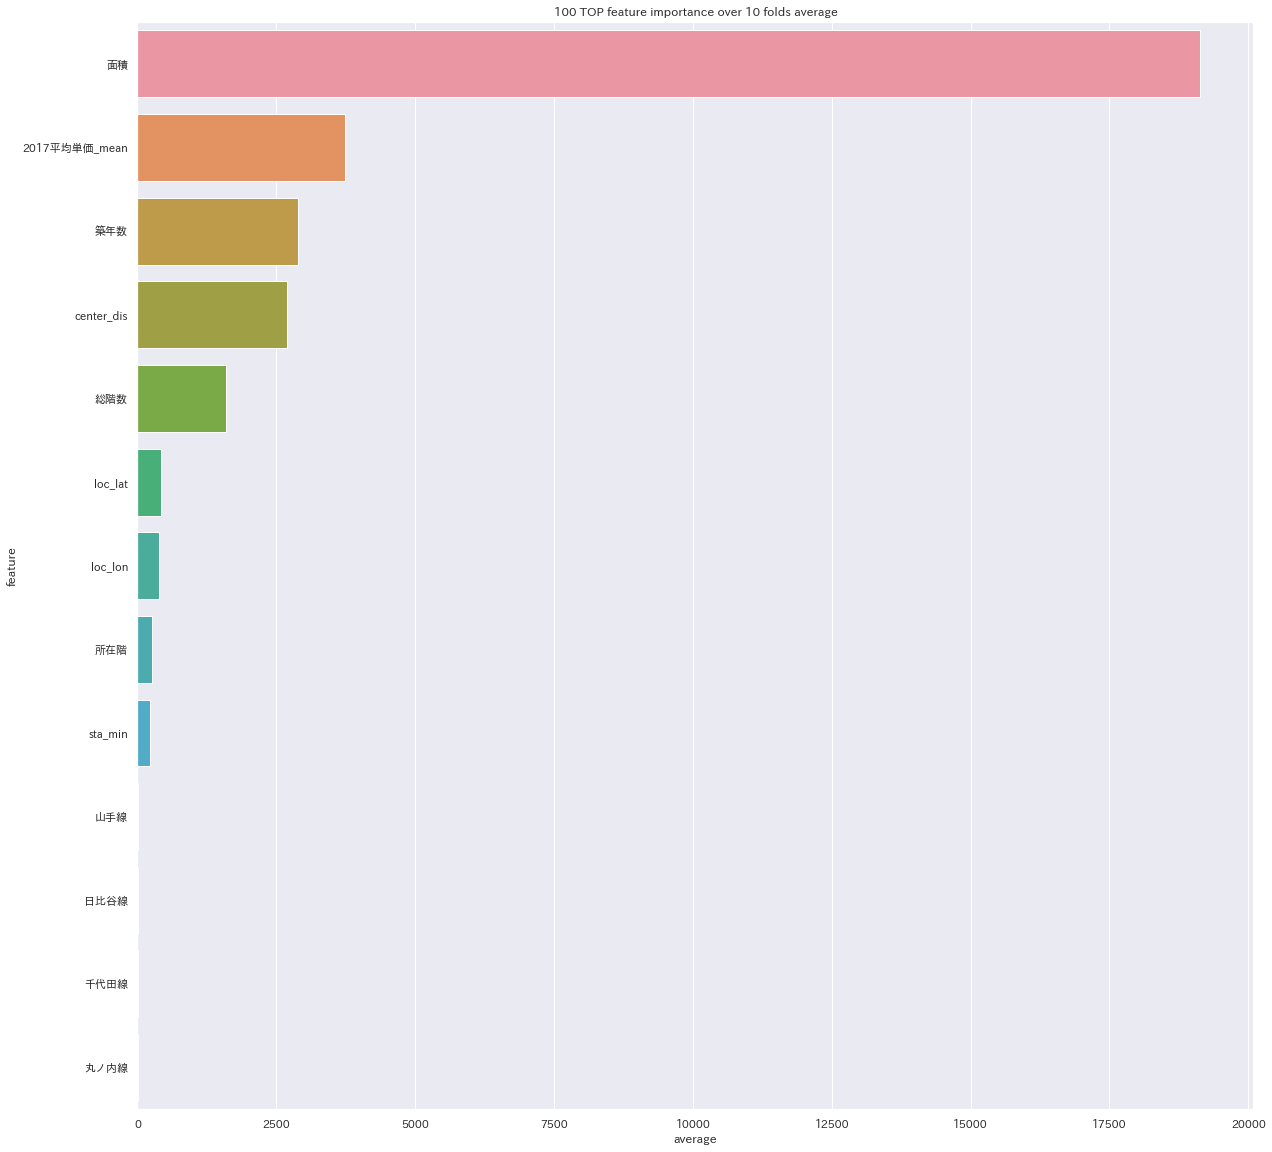

In [9]:
kf = KFold(n_splits=n_splits, random_state=SEED)

rmses = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
predictions = pd.DataFrame({'id':list(test.id.values)})
oof = pd.DataFrame({'id':list(train.id.values),'y_train':list(y_train.values)})
training_start_time = time()

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    tr_x, tr_y = X_train.iloc[trn_idx], y_train_log.iloc[trn_idx]
    vl_x, vl_y = X_train.iloc[val_idx], y_train_log.iloc[val_idx]
    print(len(tr_x), len(vl_y))
    
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    clf = lgb.train(params, tr_data, 5000, valid_sets = [tr_data, vl_data], verbose_eval=500, early_stopping_rounds=20)
    oof.loc[val_idx,'oof'] = np.expm1(clf.predict(vl_x, num_iteration=clf.best_iteration))
    
    ## アンサンブル
    print('start predict')
    pred = clf.predict(X_test)
    predictions['pred'+str(fold)] = np.expm1(pred)
 
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance('gain')
    rmses.append(clf.best_score['valid_1']['l1'])
    
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
    gc.collect()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean RMSE:', np.mean(rmses))
print('-' * 30)

feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for kf in range(kf.n_splits)]].mean(axis=1)

plt.figure(figsize=(20, 20))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over {} folds average'.format(kf.n_splits));

Training on fold 1
28320 3147
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0512503	valid_1's l1: 0.0673808
[1000]	training's l1: 0.0397384	valid_1's l1: 0.0633645
[1500]	training's l1: 0.0323568	valid_1's l1: 0.0610874
[2000]	training's l1: 0.0271325	valid_1's l1: 0.0595055
[2500]	training's l1: 0.0231976	valid_1's l1: 0.0587424
[3000]	training's l1: 0.019937	valid_1's l1: 0.0579417
[3500]	training's l1: 0.0175637	valid_1's l1: 0.057521
[4000]	training's l1: 0.015521	valid_1's l1: 0.0571287
[4500]	training's l1: 0.0137639	valid_1's l1: 0.0566941
[5000]	training's l1: 0.0122945	valid_1's l1: 0.0564195
[5500]	training's l1: 0.0110245	valid_1's l1: 0.0561845
[6000]	training's l1: 0.00996082	valid_1's l1: 0.0559532
[6500]	training's l1: 0.00904105	valid_1's l1: 0.0557503
[7000]	training's l1: 0.00823736	valid_1's l1: 0.0555937
[7500]	training's l1: 0.00753819	valid_1's l1: 0.0554531
Early stopping, best iteration is:
[7615]	training's l1: 0.00739159	

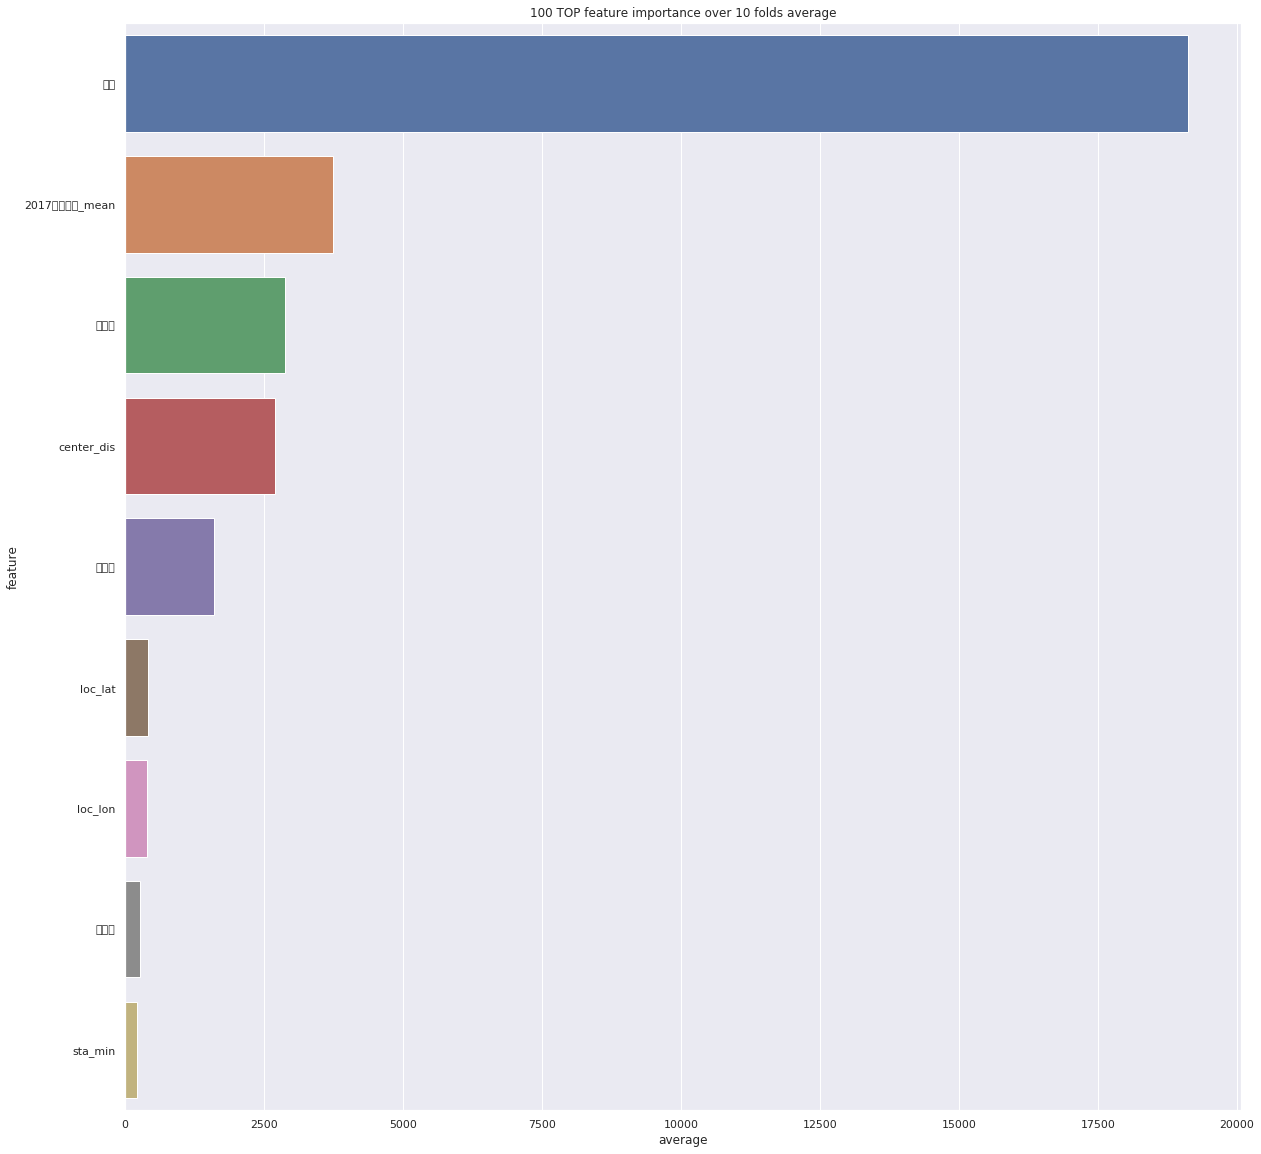

In [79]:
kf = KFold(n_splits=n_splits, random_state=SEED)

rmses = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
predictions = pd.DataFrame({'id':list(test.id.values)})
oof = pd.DataFrame({'id':list(train.id.values),'y_train':list(y_train.values)})
training_start_time = time()

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    tr_x, tr_y = X_train.iloc[trn_idx], y_train_log.iloc[trn_idx]
    vl_x, vl_y = X_train.iloc[val_idx], y_train_log.iloc[val_idx]
    print(len(tr_x), len(vl_y))
    
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    clf = lgb.train(params, tr_data, 5000, valid_sets = [tr_data, vl_data], verbose_eval=500, early_stopping_rounds=20)
    oof.loc[val_idx,'oof'] = np.expm1(clf.predict(vl_x, num_iteration=clf.best_iteration))
    
    ## アンサンブル
    print('start predict')
    pred = clf.predict(X_test)
    predictions['pred'+str(fold)] = np.expm1(pred)
 
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance('gain')
    rmses.append(clf.best_score['valid_1']['l1'])
    
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
    gc.collect()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean RMSE:', np.mean(rmses))
print('-' * 30)

feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for kf in range(kf.n_splits)]].mean(axis=1)

plt.figure(figsize=(20, 20))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over {} folds average'.format(kf.n_splits));

RMSE :  18995.101781469675
R^2 :  0.9269988358735636


Text(0, 0.5, 'correct')

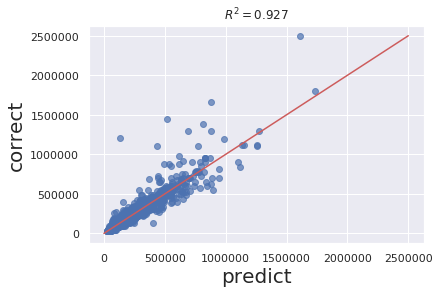

In [80]:
#validationのずれを確認する
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('RMSE : ',np.sqrt(mean_squared_error(oof['oof'], oof['y_train'])))
print('R^2 : ',r2_score(oof['oof'], oof['y_train']))
plt.figure()
plt.scatter(oof['oof'], oof['y_train'], alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(oof['oof'], oof['y_train'])))
x = np.linspace(0, 2500000, 100)
plt.plot(x, x, c="indianred")
plt.xlabel('predict',size=20)
plt.ylabel('correct',size=20)